In [ ]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np

In [ ]:
# Parameters
input_gpkg = "grav_win_geog_sirgas2000.gpkg"
layer_name = "grav"  #
output_gpkg = "grav_win_geog_sirgas2000_filtrado.gpkg"
coluna_valores = "GRAV_OBS" 

# Window
janela_km = 30 # km
limite_std = 5  # desvios padrão para detectar outlier
stride_km = 10  # km, sobreposição de 10 km

In [37]:
gdf = gpd.read_file(input_gpkg, layer=layer_name)

# CRS
if not gdf.crs or not gdf.crs.is_projected:
    gdf = gdf.to_crs('EPSG:5880')
    #raise ValueError("O CRS deve estar em metros. GDF reprojetado.")

In [ ]:
# Remover os dados de "zanella", pois estão todos com desvio dos pontos lidos ao redor
gdf = gdf[~gdf['source_file'].str.contains("zanella", case=False, na=False)]


## Using convolutional search

In [ ]:
# # Kernel
janela_m = janela_km * 1000
stride_m = stride_km * 1000

bounds = gdf.total_bounds  # xmin, ymin, xmax, ymax
xmin, ymin, xmax, ymax = bounds

x_coords = np.arange(xmin, xmax, janela_m)
y_coords = np.arange(ymin, ymax, janela_m)

indices_validos = set()

# Filtering
pontos_filtrados = []

for x in x_coords:
    for y in y_coords:
        janela = box(x, y, x + janela_m, y + janela_m)
        dentro = gdf[gdf.geometry.within(janela)]
        
        if len(dentro) < 5:
            continue

        valores = dentro[coluna_valores]
        media = valores.mean()
        desvio = valores.std()

        # Índices dos que NÃO são outliers
        nao_outliers = dentro[np.abs(valores - media) <= limite_std * desvio]
        indices_validos.update(nao_outliers.index)


In [57]:
# GeoDataFrame with valid values
gdf_filtrado = gdf.loc[sorted(indices_validos)].copy()

# Save file 
gdf_filtrado.to_file(output_gpkg, layer="grav_filt", driver="GPKG")

print(f"Arquivo salvo como: {output_gpkg}")
print(f"Pontos finais: {len(gdf_filtrado)} de {len(gdf)} (removidos: {len(gdf) - len(gdf_filtrado)})")

Arquivo salvo como: grav_win_geog_sirgas2000_filtrado.gpkg
Pontos finais: 77362 de 77667 (removidos: 305)


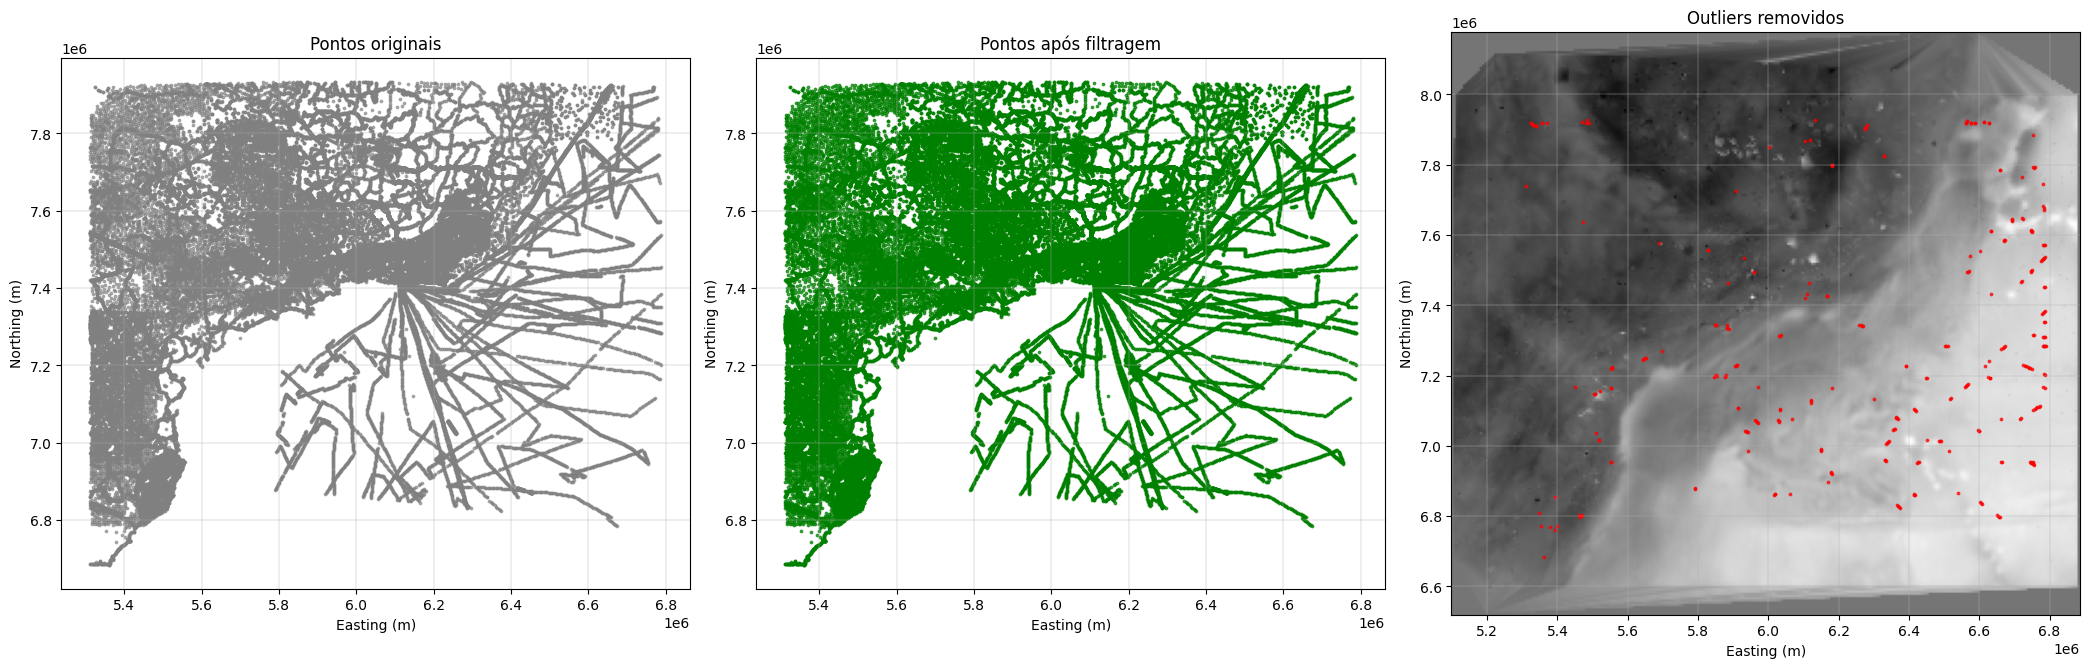

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

gdf_original = gdf

with rasterio.open('gridded_bouguer_d2000.tif') as src:
    img = src.read(1) 
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

outliers = gdf[~gdf.index.isin(gdf_filtrado.index)]

fig, axs = plt.subplots(1, 3, figsize=(21, 7))

gdf.plot(ax=axs[0], markersize=3, color='gray', alpha=0.6)
axs[0].set_title("Pontos originais")
axs[0].set_xlabel("Easting (m)")
axs[0].set_ylabel("Northing (m)")
axs[0].grid(True, linewidth=0.3)

gdf.plot(ax=axs[1], markersize=3, color='green', alpha=0.7)
axs[1].set_title("Pontos após filtragem")
axs[1].set_xlabel("Easting (m)")
axs[1].set_ylabel("Northing (m)")
axs[1].grid(True, linewidth=0.3)

axs[2].imshow(img, extent=extent, origin='upper', cmap='Greys_r')
outliers.plot(ax=axs[2], markersize=3, color='red', alpha=0.7)
axs[2].set_title("Outliers removidos")
axs[2].set_xlabel("Easting (m)")
axs[2].set_ylabel("Northing (m)")
axs[2].grid(True, linewidth=0.3)

plt.tight_layout()
plt.show()


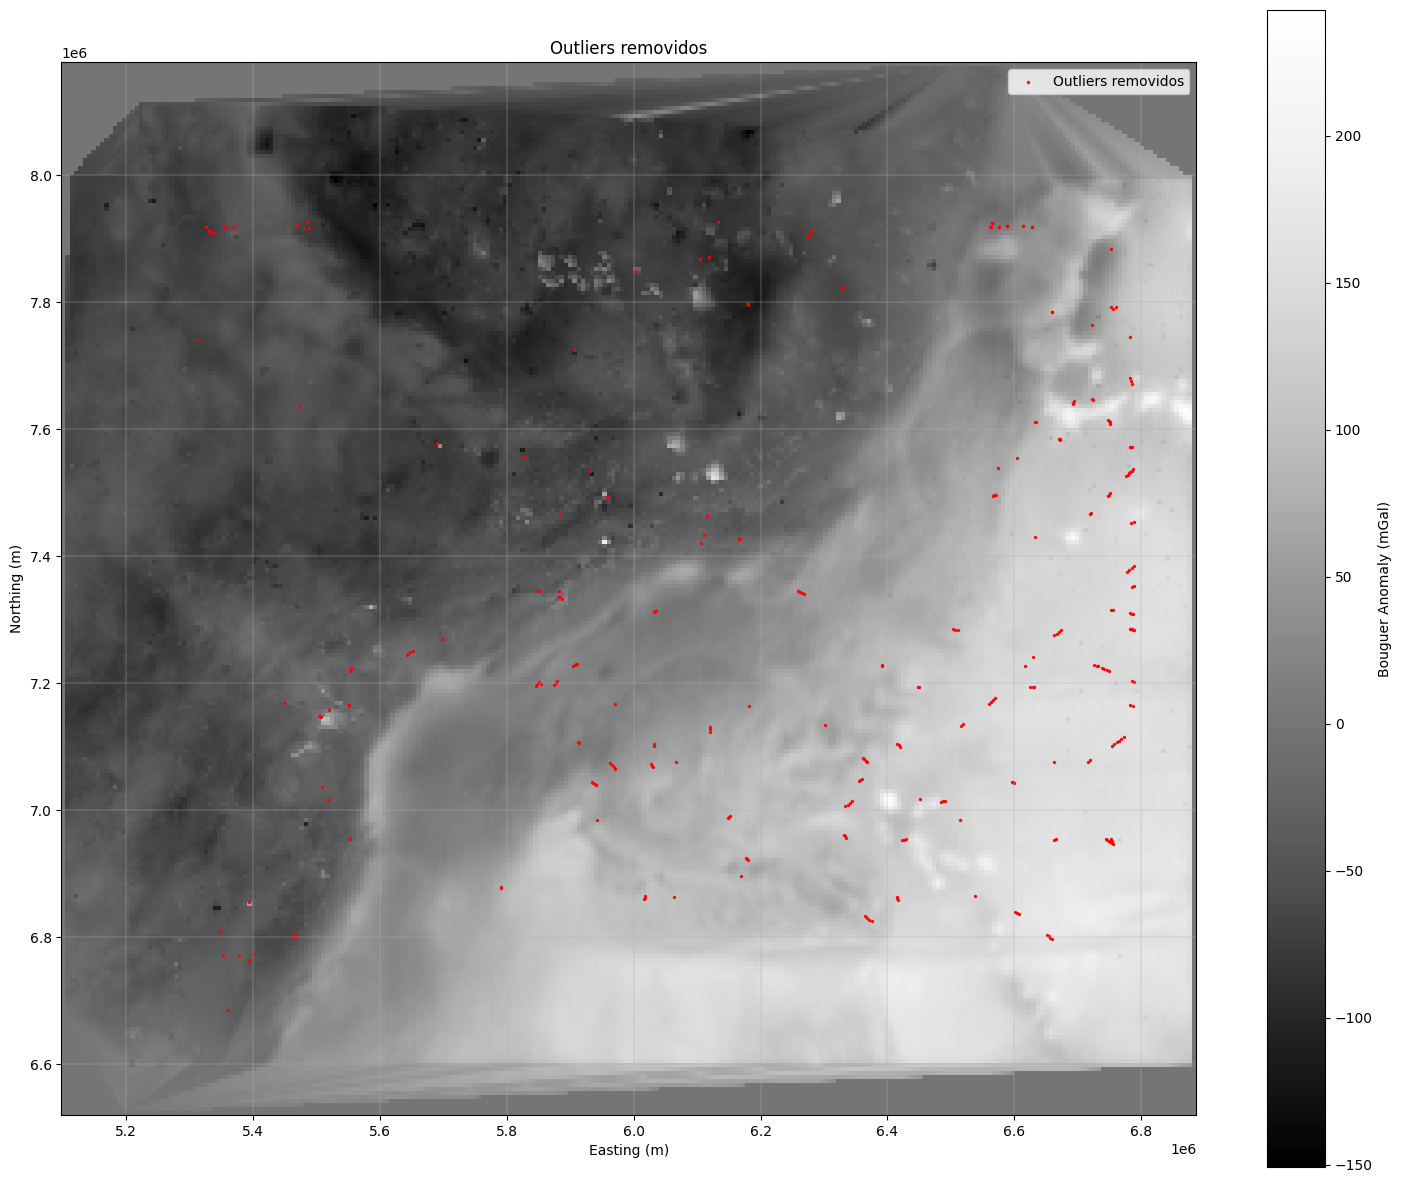

In [59]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np

outliers = gdf[~gdf.index.isin(gdf_filtrado.index)]

outliers.to_file('outliers_6sigma_win30km.gpkg', layer="grav_out", driver="GPKG")

fig, ax = plt.subplots(figsize=(15, 12))

im = ax.imshow(img, extent=extent, origin='upper', cmap='Greys_r')
plt.colorbar(im, ax=ax, label="Bouguer Anomaly (mGal)")
outliers.plot(ax=ax, markersize=2, color='red', alpha=0.9, label="Outliers removidos")
ax.set_title("Outliers removidos")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.grid(True, linewidth=0.3)
ax.legend()

plt.tight_layout()
plt.show()


## by Nearest Neighbours

In [ ]:
import geopandas as gpd
import numpy as np
from sklearn.neighbors import KDTree

limite_std = 6  # desvios padrão para detectar outlier
k = 15

coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
tree = KDTree(coords)

# Mask using valid numbers
indices_validos = np.ones(len(gdf), dtype=bool)

# Verifying
valores = gdf[coluna_valores].values

for i, ponto in enumerate(coords):
    # Obter os vizinhos (k+1, inclui ele mesmo como o primeiro)
    dist, idx = tree.query([ponto], k=k+1)
    idx_vizinhos = idx[0][1:]  # exclui o próprio

    vizinhos_valores = valores[idx_vizinhos]
    media = vizinhos_valores.mean()
    desvio = vizinhos_valores.std()

    if desvio > 0 and abs(valores[i] - media) > limite_std * desvio:
        indices_validos[i] = False

gdf_filtrado = gdf[indices_validos]
gdf_outliers = gdf[~indices_validos]

output_gpkg = str('grav_win_geog_sirgas2000_filtrado'+f'_{limite_std}sigma_{k}nn.gpkg')
gdf_filtrado.to_file(output_gpkg, layer="grav_filt", driver="GPKG")
gdf_outliers.to_file(f'outliers_{limite_std}sigma_{k}nn.gpkg', layer="grav_out", driver="GPKG")

print(f"Pontos filtrados: {len(gdf_filtrado)} de {len(gdf)} (outliers: {len(gdf_outliers)})")


Pontos filtrados: 77510 de 77667 (outliers: 157)


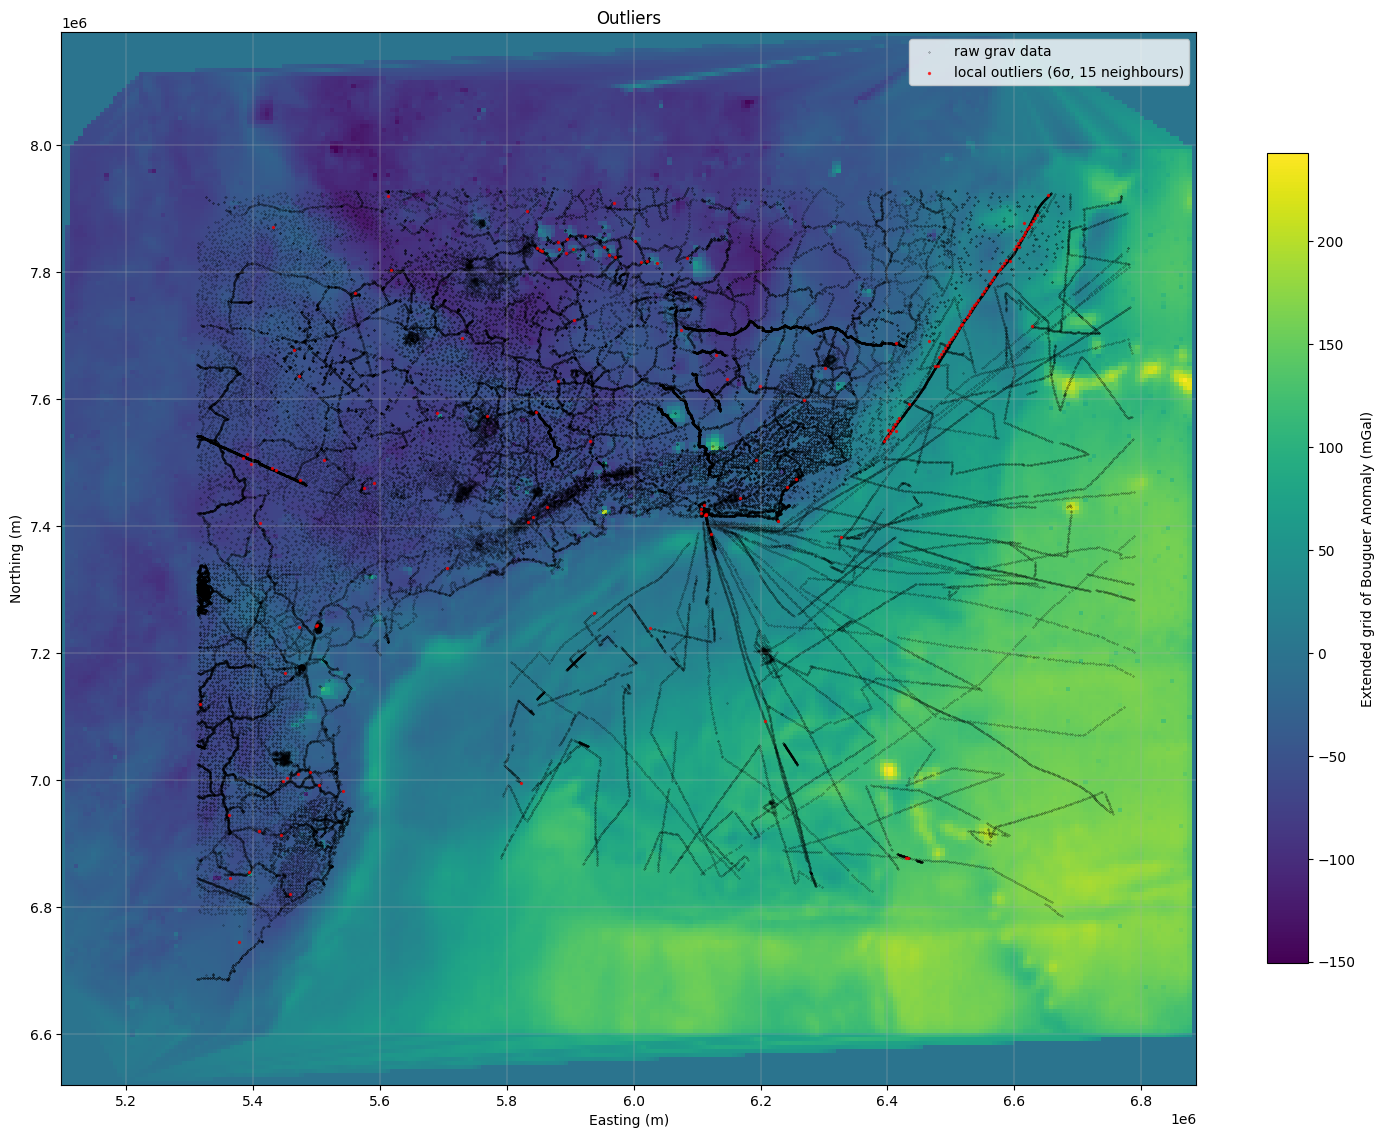

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
im = ax.imshow(img, extent=extent, origin='upper', cmap='viridis')
plt.colorbar(im, ax=ax, label="Extended grid of Bouguer Anomaly (mGal)", shrink=0.7)
gdf.plot(ax=ax, markersize=0.05, color='k', alpha=0.9, label="raw grav data")
gdf_outliers.plot(ax=ax, markersize=2, color='red', alpha=0.7, label=f"local outliers ({limite_std}σ, {k} neighbours)")
ax.set_title("Outliers")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.grid(True, linewidth=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [94]:
import os

coluna_valores = "GRAV_OBS"
k = 15
limite_std = 6
output_dir = "outlier_inspecao"

os.makedirs(output_dir, exist_ok=True)

coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
valores = gdf[coluna_valores].values
tree = KDTree(coords)

# Outliers and calc average distance to the neigbors
outlier_infos = []

for i, ponto in enumerate(coords):
    dist, idx = tree.query([ponto], k=k+1)
    idx_vizinhos = idx[0][1:]
    dist_vizinhos = dist[0][1:]
    media = valores[idx_vizinhos].mean()
    desvio = valores[idx_vizinhos].std()

    if desvio > 0 and abs(valores[i] - media) > limite_std * desvio:
        outlier_infos.append({
            "index": i,
            "media_dist": np.mean(dist_vizinhos),
            "vizinho_idx": idx_vizinhos
        })

# Top 20 outliers with the furthest neighbors
outlier_infos.sort(key=lambda x: x["media_dist"], reverse=True)
outlier_infos_top = outlier_infos[:20]

for j, info in enumerate(outlier_infos_top):
    idx = info["index"]
    viz_idx = info["vizinho_idx"]

    ponto_outlier = gdf.iloc[[idx]]
    vizinhos = gdf.iloc[viz_idx]

    fig, ax = plt.subplots(figsize=(8, 8))
    vizinhos.plot(ax=ax, color='gray', markersize=30, label='Vizinhos')
    ponto_outlier.plot(ax=ax, color='red', markersize=80, label='Outlier')

    ax.set_title(f"Outlier {j+1} - índice {idx} - média distância {info['media_dist']:.1f} m")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.grid(True, linewidth=0.3)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/outlier_{j+1}_idx{idx}.png", dpi=300)
    plt.close()

print(f"Salvo {len(outlier_infos_top)} mapas no diretório: {output_dir}")
print(f"Pontos filtrados: {len(gdf_filtrado)} de {len(gdf)} (outliers: {len(gdf_outliers)})")


Salvo 20 mapas no diretório: outlier_inspecao
Pontos filtrados: 77510 de 77667 (outliers: 157)


In [95]:
gdf_filtrado.head()

,LATITUDE,LONGITUDE,GRAV_OBS,ALT_ORT,source_file,geometry
0,-29.77850,-50.17630,979265.73,16.09,on_bndg.zip,POINT (5369683.45 6698312.977)
1,-29.77811,-50.17436,979265.70,0.00,ibge.zip,POINT (5369872.379 6698350.039)
2,-29.77810,-50.17580,979265.73,16.09,on_bndg.zip,POINT (5369733.244 6698355.764)
3,-29.77100,-50.19520,979268.40,NaN,on_bndg.zip,POINT (5367884.263 6699205.692)
4,-29.77060,-50.19470,979268.40,7.75,on_bndg.zip,POINT (5367934.054 6699248.487)
